# Compare Linearized Prior

In [1]:
import numpy as np
import os
import wandb
import matplotlib.pyplot as plt
import tensorflow as tf
from gpflow.config import default_float
from gpflow.likelihoods import Gaussian

from docs.sde.sde_exp_utils import generate_dw_data
from markovflow.sde.sde import PriorDoubleWellSDE
from markovflow.models.cvi_sde import SDESSM
from markovflow.models.vi_sde import VariationalMarkovGP

from IPython.display import clear_output


2022-07-11 10:37:54.438029: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-11 10:37:54.438048: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-07-11 10:37:56.033798: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-11 10:37:56.038090: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-07-11 10:37:56.095102: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 10:37:56.095929: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties

In [2]:
os.environ['WANDB_MODE'] = 'offline'
wandb.init()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [3]:
# Set seed
tf.random.set_seed(12)
np.random.seed(12)

## Parameters

In [4]:
DTYPE = default_float()
q = 1.2
x0 = 1.
t0 = 0.
t1 = 30.
dt = 0.01
noise_var = 0.01

## Generate Data

In [5]:
obs_vals, obs_grid, latent_process, time_grid, _, _, _ = generate_dw_data(q=q, x0=x0, t0=t0, t1=t1,
                                                                            simulation_dt=dt,
                                                                            noise_stddev=np.sqrt(noise_var),
                                                                            n_observations=100,
                                                                            dtype=DTYPE)

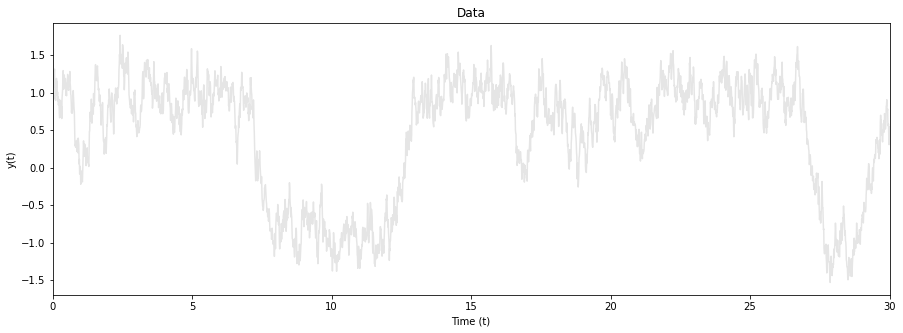

In [6]:
plt.rcParams["figure.figsize"] = [15, 5]
plt.plot(time_grid, tf.reshape(latent_process, (-1)), label="Latent Process", alpha=0.2, color="gray")
plt.xlabel("Time (t)")
plt.ylabel("y(t)")
plt.xlim([t0, t1])
plt.title("Data")
plt.show()

In [7]:
# Prior SDE
true_q = q * tf.ones((1, 1), dtype=DTYPE)
prior_sde = PriorDoubleWellSDE(q=true_q, initial_a_val=4., initial_c_val=1.)

# likelihood
likelihood = Gaussian(noise_var)

obs_data = (obs_grid, tf.squeeze(obs_vals, axis=0))

## SDE-SSM

In [8]:
ssm_model = SDESSM(input_data=obs_data, prior_sde=prior_sde, grid=time_grid, likelihood=likelihood, learning_rate=.9)

# Set initial statistics and posterior path
# ssm_model.initial_mean = 1. + 0. * ssm_model.initial_mean
# ssm_model.initial_chol_cov = .5 + 0. * ssm_model.initial_chol_cov

ssm_model.run()


2022-07-11 10:38:04.367167: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


SSM: Starting ELBO -4588.719426854678;
SSM: ELBO -393.09983944481974!!!
SSM: ELBO -384.02199189122723!!!
SSM: ELBO -383.26742130070977!!!
SSM: ELBO -383.1933087668118!!!
SSM: ELBO -383.18591079183614!!!
SSM: ELBO -383.185171126962!!!
SSM: Sites Converged!!!
SSM: Prior SDE (learnt and) re-linearized: ELBO -388971768.71439636;!!!
SSM: ELBO decreasing! Decaying LR!!!
SSM: ELBO -388971619.70852166!!!
SSM: Sites Converged!!!
SSM: Prior SDE (learnt and) re-linearized: ELBO -58.19152405889531;!!!
SSM: ELBO -64.89758449815315!!!
SSM: ELBO decreasing! Decaying LR!!!
SSM: Sites Converged!!!
SSM: Prior SDE (learnt and) re-linearized: ELBO -61.53642277335965;!!!
SSM: ELBO -62.40583385492401!!!
SSM: ELBO decreasing! Decaying LR!!!
SSM: Sites Converged!!!
SSM: Prior SDE (learnt and) re-linearized: ELBO -60.79846701252868;!!!
SSM: ELBO -60.92339670723077!!!
SSM: ELBO decreasing! Decaying LR!!!
SSM: Sites Converged!!!
SSM: Prior SDE (learnt and) re-linearized: ELBO -61.159399764475026;!!!
SSM: ELBO de

KeyboardInterrupt: 

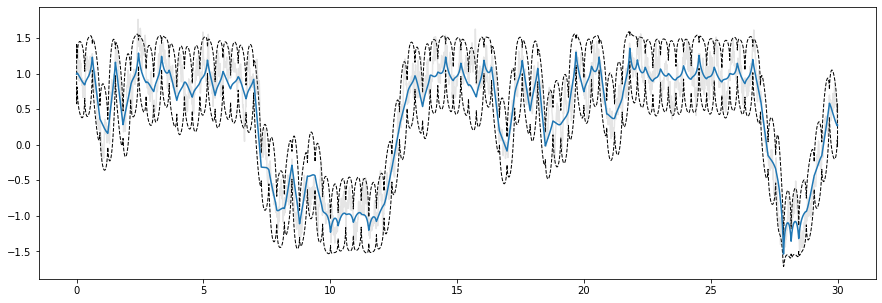

In [9]:
plt.rcParams["figure.figsize"] = [15, 5]
plt.plot(time_grid, tf.reshape(latent_process, (-1)), label="Latent Process", alpha=0.2, color="gray")

plt.plot(time_grid, ssm_model.fx_mus.numpy().reshape(-1))
plt.fill_between(
            time_grid,
            y1=(ssm_model.fx_mus.numpy().reshape(-1) - 2 * np.sqrt(ssm_model.fx_covs.numpy().reshape(-1))),
            y2=(ssm_model.fx_mus.numpy().reshape(-1) + 2 * np.sqrt(ssm_model.fx_covs.numpy().reshape(-1))),
            edgecolor="black",
            facecolor=(0, 0, 0, 0.),
            linestyle='dashed'
        )

In [10]:
ssm_lin_prior_marginals = ssm_model.dist_p_ssm.marginals

ssm_lin_prior_m = ssm_lin_prior_marginals[0].numpy().reshape(-1)
ssm_lin_prior_S = ssm_lin_prior_marginals[1].numpy().reshape(-1)

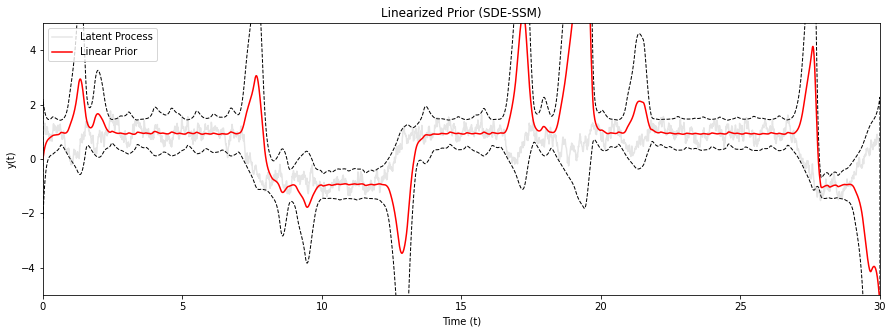

In [16]:
plt.rcParams["figure.figsize"] = [15, 5]
plt.plot(time_grid, tf.reshape(latent_process, (-1)), label="Latent Process", alpha=0.2, color="gray")

plt.plot(time_grid, ssm_lin_prior_m, label="Linear Prior", color="red")
plt.fill_between(
            time_grid,
            y1=(ssm_lin_prior_m - 2 * np.sqrt(ssm_lin_prior_S)),
            y2=(ssm_lin_prior_m + 2 * np.sqrt(ssm_lin_prior_S)),
            edgecolor="black",
            facecolor=(0, 0, 0, 0.),
            linestyle='dashed'
        )

plt.xlabel("Time (t)")
plt.ylabel("y(t)")
plt.xlim([t0, t1])
plt.ylim([-5 ,5])
plt.title("Linearized Prior (SDE-SSM)")
plt.legend()
plt.show()

## VGP

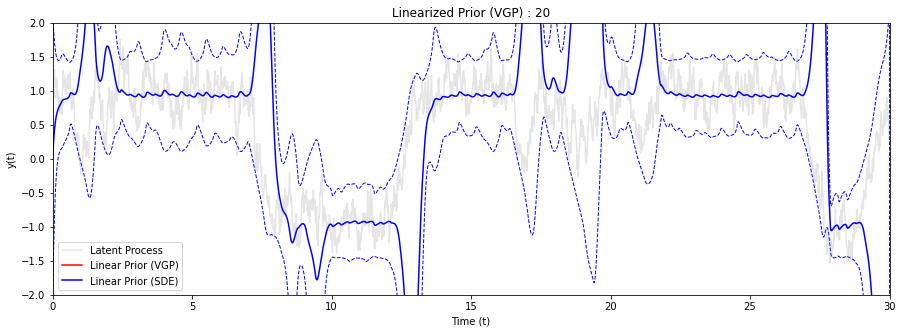

KeyboardInterrupt: 

Error in callback <function _WandbInit._pause_backend at 0x7fd8fc576b90> (for post_run_cell):


Exception: The wandb backend process has shutdown

In [19]:
vgp_model = VariationalMarkovGP(input_data=obs_data, prior_sde=prior_sde, grid=time_grid, likelihood=likelihood,
                               lr=.5)

# Set VGP model params as close as possible to SDE-SSM
vgp_model.p_initial_cov = tf.reshape(tf.square(ssm_model.initial_chol_cov), vgp_model.p_initial_cov.shape)
vgp_model.p_initial_mean = tf.reshape(ssm_model.initial_mean, vgp_model.p_initial_mean.shape)

vgp_model.q_initial_mean = tf.reshape(ssm_model.fx_mus[:, 0], vgp_model.q_initial_mean.shape)
vgp_model.q_initial_cov = tf.reshape(ssm_model.fx_covs[:, 0], shape=vgp_model.q_initial_cov.shape)

# Run inference without observations so that prior is linearized
converged = False
itr = 0

for _ in range(40):
    m, S = vgp_model.forward_pass
    vgp_model.update_lagrange(m, S)
    converged = vgp_model.update_param(m, S)
    
    vgp_m, vgp_S = vgp_model.forward_pass

    vgp_m = vgp_m.numpy().reshape(-1)
    vgp_S = vgp_S.numpy().reshape(-1)
    itr += 1
    
    if itr %2 == 0:
        clear_output(wait=True)
        plt.rcParams["figure.figsize"] = [15, 5]
        plt.plot(time_grid, tf.reshape(latent_process, (-1)), label="Latent Process", alpha=0.2, color="gray")

        plt.plot(time_grid, vgp_m, label="Linear Prior (VGP)", color="red")
        plt.fill_between(
                    time_grid,
                    y1=(vgp_m - 2 * np.sqrt(vgp_S)),
                    y2=(vgp_m + 2 * np.sqrt(vgp_S)),
                    edgecolor="red",
                    facecolor=(0, 0, 0, 0.),
                    linestyle='dashed'
                )
        
        plt.plot(time_grid, ssm_lin_prior_m, label="Linear Prior (SDE)", color="blue")
        plt.fill_between(
            time_grid,
            y1=(ssm_lin_prior_m - 2 * np.sqrt(ssm_lin_prior_S)),
            y2=(ssm_lin_prior_m + 2 * np.sqrt(ssm_lin_prior_S)),
            edgecolor="blue",
            facecolor=(0, 0, 0, 0.),
            linestyle='dashed'
        )
        
        plt.xlabel("Time (t)")
        plt.ylabel("y(t)")
        plt.xlim([t0, t1])
        plt.ylim([-2 ,2])
        plt.title("Linearized Prior (VGP) : " + str(itr))
        plt.legend()
        plt.show()

In [ ]:
vgp_model.b

In [ ]:
plt.rcParams["figure.figsize"] = [15, 5]
plt.plot(time_grid, tf.reshape(latent_process, (-1)), label="Latent Process", alpha=0.2, color="gray")

plt.plot(time_grid, vgp_m, label="Linear Prior", color="red")
plt.fill_between(
            time_grid,
            y1=(vgp_m - 2 * np.sqrt(vgp_S)),
            y2=(vgp_m + 2 * np.sqrt(vgp_S)),
            edgecolor="black",
            facecolor=(0, 0, 0, 0.),
            linestyle='dashed'
        )

plt.xlabel("Time (t)")
plt.ylabel("y(t)")
plt.xlim([t0, t1])
plt.title("Linearized Prior (VGP)")
plt.legend()
plt.show()